Using 19 bonds in the model:
- 020002BJ9 (Insurance): Qty=17.50, PMV=0.46, DXS=205.58
- 026874DS3 (Insurance): Qty=17.50, PMV=0.56, DXS=337.86
- 081437AT2 (Capital_Goods): Qty=17.50, PMV=0.50, DXS=233.03
- 097023CJ2 (Capital_Goods): Qty=9.00, PMV=0.25, DXS=310.15
- 13645RAD6 (Transportation): Qty=32.50, PMV=1.18, DXS=1.18
- 13645RBF0 (Transportation): Qty=23.00, PMV=0.64, DXS=0.64
- 14448CBC7 (Capital_Goods): Qty=17.50, PMV=0.59, DXS=393.28
- 15135BAW1 (Insurance): Qty=17.50, PMV=0.49, DXS=378.46
- 21871XAS8 (Insurance): Qty=17.50, PMV=0.58, DXS=472.07
- 24422EWZ8 (Capital_Goods): Qty=11.00, PMV=0.36, DXS=81.61
- 24422EXP9 (Capital_Goods): Qty=17.50, PMV=0.57, DXS=281.94
- 314353AA1 (Transportation): Qty=32.50, PMV=0.70, DXS=0.70
- 36166NAK9 (Capital_Goods): Qty=17.50, PMV=0.56, DXS=261.48
- 438516CM6 (Capital_Goods): Qty=17.50, PMV=0.55, DXS=236.65
- 443201AC2 (Capital_Goods): Qty=10.00, PMV=0.32, DXS=141.55
- 444859BR2 (Insurance): Qty=11.50, PMV=0.30, DXS=226.71
- 444859BV3 (Insuran

C:\Users\macke\AppData\Local\Temp\ipykernel_15448\2186813021.py:256: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Iteration 10: Energy 1.937252
Iteration 20: Energy -0.397163
Iteration 30: Energy -0.562150
Iteration 40: Energy -0.673437
Iteration 50: Energy -0.652323
Iteration 60: Energy -0.680695
Iteration 70: Energy -0.682673
Iteration 80: Energy -0.684059
Iteration 90: Energy -0.684330
Iteration 100: Energy -0.685346
Iteration 110: Energy -0.686190
Iteration 120: Energy -0.686810
Iteration 130: Energy -0.688308
Iteration 140: Energy -0.689348
Iteration 150: Energy -0.690865
Iteration 160: Energy -0.691656
Iteration 170: Energy -0.692847
Iteration 180: Energy -0.694246
Iteration 190: Energy -0.697164
Iteration 200: Energy -0.698493

QAOA Results:
Optimal value (final loss): -0.698642
Optimization time: 5339.17 seconds


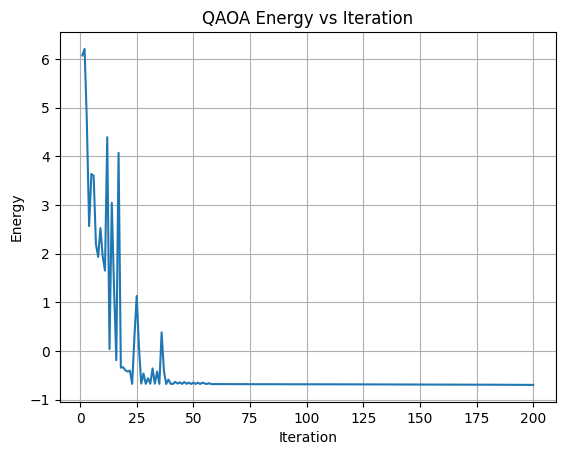

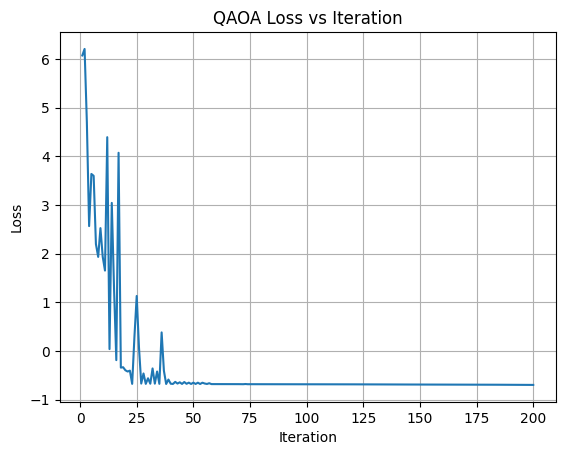


Top Portfolio Solutions:

Solution #1 (Frequency: 2.9%)
Selected bonds (1): ['314353AA1']
Total PMV: 0.70 | Cash Constraint: ❌

Capital_Goods:
  PMV: 0.00 (Target: 5.80, Diff: -5.80) ❌
  DXS: 0.00 [Min: 1780.69, Max: 3869.83] ❌

Insurance:
  PMV: 0.00 (Target: 5.18, Diff: -5.18) ❌
  DXS: 0.00 [Min: 1991.43, Max: 4080.57] ❌

Transportation:
  PMV: 0.70 (Target: 1.28, Diff: -0.59) ❌
  DXS: 0.70 [Min: -479.88, Max: 10.44] ✅
Constraints: ❌
Violations:
  - Cash (0.70 not in [2.600974180557, 10.435233760548])
  - Capital_Goods PMV (0.00 not in [4.76, 0.00])
  - Insurance PMV (0.00 not in [4.13, 0.00])
  - Transportation PMV (0.70 not in [0.24, 0.00])
  - Capital_Goods DXS (0.00 not in [1780.69, 3869.83])
  - Insurance DXS (0.00 not in [1991.43, 4080.57])

Bond Selection Mask:
  020002BJ9: 0
  026874DS3: 0
  081437AT2: 0
  097023CJ2: 0
  13645RAD6: 0
  13645RBF0: 0
  14448CBC7: 0
  15135BAW1: 0
  21871XAS8: 0
  24422EWZ8: 0
  24422EXP9: 0
  314353AA1: 1
  36166NAK9: 0
  438516CM6: 0
  443201

In [1]:
import numpy as np
import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.minimum_eigensolvers import QAOA
from collections import defaultdict
import json
from qiskit_algorithms.utils import algorithm_globals

import matplotlib.pyplot as plt

shots = 10_000
json_path = 'bond_data.json'

# Configuration parameters
WEIGHTS = {
    'pmv_objective': 36.0,
    'dxs_objective': 36.0,
    'max_bonds': 1000.0,          #  upper-bound 
    'cash_constraint': 50.0,      # used per side 
    'sector_pmv_constraint': 100.0,  # per side
    'sector_dxs_constraint': 100.0,  # per side 
    'binary_constraint': 100.0    # per side 
}

BENCHMARK_VALUE = 1000000 

# Load data from JSON file
with open(json_path, 'r') as f:
     data = json.load(f)
data['cash_min'] = 2.600974180557
data['cash_max'] = 10.435233760548

# Extract data
all_bonds = data['bonds']
sector_data = data['sector_data']
cash_min = data['cash_min']
cash_max = data['cash_max']
cash_mid = (cash_min + cash_max) / 2 

# User-configurable parameters
MAX_BONDS = 19  # N in the problem statement
SELECTED_BONDS = None 

# Select bonds to include in the model
if SELECTED_BONDS:
    bonds = [bond for bond in all_bonds if bond['id'] in SELECTED_BONDS]
elif MAX_BONDS:
    bonds = all_bonds[:MAX_BONDS]
else:
    bonds = all_bonds

print(f"Using {len(bonds)} bonds in the model:")

# Calculate fixed trade quantity for each bond
for bond in bonds:
    # Get parameters with defaults
    basket_inv = bond.get('basket_inventory', bond['max'])
    delta_c = bond.get('delta_c', 1.0)
    effective_max = min(bond['max'], basket_inv)
    bond['fixed_qty'] = (bond['min'] + effective_max) / (2 * delta_c)
    bond['pmv_contrib'] = bond['pmv'] * bond['fixed_qty']
    bond['dxs_contrib'] = bond['dxs'] * bond['fixed_qty']

    print(f"- {bond['id']} ({bond['sector']}): "
          f"Qty={bond['fixed_qty']:.2f}, "
          f"PMV={bond['pmv_contrib']:.2f}, "
          f"DXS={bond['dxs_contrib']:.2f}")

# Group bonds by sector
sector_bonds = defaultdict(list)
for bond in bonds:
    sector_bonds[bond['sector']].append(bond)

# Initialize Hamiltonian
num_bonds = len(bonds)
h_total = SparsePauliOp.from_list([("I" * num_bonds, 0.0)])

# QUBO accumulator
def init_qubo(n):
    return {}, [0.0]*n, 0.0  # (Q dict with (i,j)->val for i<=j, c list, K float)


def add_quadratic_penalty_qubo(Q, cvec, K, coeffs, target, lam, n):
    # coeffs: dict {i: c_i} over variable indices present in this penalty
    idxs = list(coeffs.keys())
    # Quadratic/off-diagonal and diagonal
    for i in idxs:
        ci = float(coeffs[i])
        # Diagonal term (x_i^2 == x_i, but keep it on diagonal in QUBO form)
        Q[(i,i)] = Q.get((i,i), 0.0) + lam * ci * ci
        for j in idxs:
            if j <= i: 
                continue
            cj = float(coeffs[j])
            Q[(i,j)] = Q.get((i,j), 0.0) + 2.0 * lam * ci * cj
    # Linear
    for i in idxs:
        ci = float(coeffs[i])
        cvec[i] += -2.0 * lam * target * ci
    # Constant
    K += lam * (target**2)
    return Q, cvec, K

# Helper functions for Pauli operations
def construct_pauli_op(qubit_indices, n_qubits):
    pauli_list = ['I'] * n_qubits
    for i in qubit_indices:
        if i < n_qubits:
            pauli_list[i] = 'Z'
    return "".join(pauli_list)

def add_quadratic_penalty(coeffs, target, penalty_weight, n_qubits):
    # Implements (sum_i c_i x_i - target)^2 in Ising form (x_i in {0,1}, Z = 1-2x)
    hamiltonian = SparsePauliOp.from_list([("I" * n_qubits, penalty_weight * target**2)])
    linear_coeff = penalty_weight * (-2 * target)

    for i, c_i in coeffs.items():
        # Linear term
        hamiltonian += SparsePauliOp.from_list([
            (construct_pauli_op([i], n_qubits), linear_coeff * c_i)
        ])

        # Quadratic terms
        for j, c_j in coeffs.items():
            if i <= j:
                coeff = penalty_weight * (2 if i == j else 1) * c_i * c_j
                if i == j:
                    hamiltonian += SparsePauliOp.from_list([
                        (construct_pauli_op([], n_qubits), coeff / 2),
                        (construct_pauli_op([i], n_qubits), -coeff / 2)
                    ])
                else:
                    hamiltonian += SparsePauliOp.from_list([
                        (construct_pauli_op([i, j], n_qubits), coeff / 4),
                        (construct_pauli_op([i], n_qubits), -coeff / 4),
                        (construct_pauli_op([j], n_qubits), -coeff / 4),
                        (construct_pauli_op([], n_qubits), coeff / 4)
                    ])
    return hamiltonian

# ====================== CONSTRAINTS ====================== #

Q_qaoa, cvec_qaoa, K_qaoa = init_qubo(num_bonds)

# 1) Maximum number of bonds in basket: sum y_c ≤ N  (no equality pull in the Hamiltonian)
max_bonds_coeffs = {i: 1 for i in range(num_bonds)}

# 2) Residual cash-flow band (two inequalities: min ≤ sum ≤ max)
cash_coeffs = {i: bond['pmv_contrib'] / BENCHMARK_VALUE for i, bond in enumerate(bonds)}
lam_cash = WEIGHTS['cash_constraint'] * 0.5  
h_total += add_quadratic_penalty(cash_coeffs, float(cash_min) / BENCHMARK_VALUE, lam_cash, num_bonds)
Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
    cash_coeffs, float(cash_min) / BENCHMARK_VALUE, lam_cash, num_bonds)
h_total += add_quadratic_penalty(cash_coeffs, float(cash_max) / BENCHMARK_VALUE, lam_cash, num_bonds)
Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
    cash_coeffs, float(cash_max) / BENCHMARK_VALUE, lam_cash, num_bonds)

# 3) Per-bucket PMV/DXS inequality bands (two-sided)
for sector, data_s in sector_data.items():
    # PMV
    pmv_coeffs = {}
    for idx, bond in enumerate(bonds):
        if bond['sector'] == sector:
            pmv_coeffs[idx] = bond['pmv_contrib'] / BENCHMARK_VALUE
    lam_pmv = WEIGHTS['sector_pmv_constraint'] * 0.5
    pmn, pmx = data_s.get('pmv_min'), data_s.get('pmv_max')
    if pmn is not None:
        h_total += add_quadratic_penalty(pmv_coeffs, pmn / BENCHMARK_VALUE, lam_pmv, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            pmv_coeffs, pmn / BENCHMARK_VALUE, lam_pmv, num_bonds)
    if pmx is not None:
        h_total += add_quadratic_penalty(pmv_coeffs, pmx / BENCHMARK_VALUE, lam_pmv, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            pmv_coeffs, pmx / BENCHMARK_VALUE, lam_pmv, num_bonds)
    # DXS
    dxs_coeffs = {}
    for idx, bond in enumerate(bonds):
        if bond['sector'] == sector:
            dxs_coeffs[idx] = bond['dxs_contrib'] / BENCHMARK_VALUE
    lam_dxs = WEIGHTS['sector_dxs_constraint'] * 0.5
    dxn, dxx = data_s.get('dxs_min'), data_s.get('dxs_max')
    if dxn is not None:
        h_total += add_quadratic_penalty(dxs_coeffs, dxn / BENCHMARK_VALUE, lam_dxs, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            dxs_coeffs, dxn / BENCHMARK_VALUE, lam_dxs, num_bonds)
    if dxx is not None:
        h_total += add_quadratic_penalty(dxs_coeffs, dxx / BENCHMARK_VALUE, lam_dxs, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            dxs_coeffs, dxx / BENCHMARK_VALUE, lam_dxs, num_bonds)

# 4) Per-bucket binary count bounds
for sector, data_s in sector_data.items():
    if 'min_bonds' in data_s or 'max_bonds' in data_s:
        count_coeffs = {}
        for idx, bond in enumerate(bonds):
            if bond['sector'] == sector:
                count_coeffs[idx] = 1.0
        lam_bin = WEIGHTS['binary_constraint'] * 0.5
        
        if 'min_bonds' in data_s:
            lb = float(data_s['min_bonds'])
            h_total += add_quadratic_penalty(count_coeffs, lb, lam_bin, num_bonds)
            Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
                count_coeffs, lb, lam_bin, num_bonds)
            
        if 'max_bonds' in data_s:
            ub = float(data_s['max_bonds'])
            h_total += add_quadratic_penalty(count_coeffs, ub, lam_bin, num_bonds)
            Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
                count_coeffs, ub, lam_bin, num_bonds)

# ====================== OBJECTIVE FUNCTION ====================== #
for sector, data_s in sector_data.items():
    # PMV target pull
    pmv_coeffs = {}
    for idx, bond in enumerate(bonds):
        if bond['sector'] == sector:
            pmv_coeffs[idx] = bond['pmv_contrib'] / BENCHMARK_VALUE
    lam = WEIGHTS['pmv_objective']
    tgt = data_s['target'] / BENCHMARK_VALUE
    h_total += add_quadratic_penalty(pmv_coeffs, tgt, lam, num_bonds)
    Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
        pmv_coeffs, tgt, lam, num_bonds)

# DXS objective
for sector, data_s in sector_data.items():
    if 'dxs_target' in data_s:
        dxs_coeffs = {}
        for idx, bond in enumerate(bonds):
            if bond['sector'] == sector:
                dxs_coeffs[idx] = bond['dxs_contrib'] / BENCHMARK_VALUE
        lam = WEIGHTS['dxs_objective']
        tgt = data_s['dxs_target'] / BENCHMARK_VALUE
        h_total += add_quadratic_penalty(dxs_coeffs, tgt, lam, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            dxs_coeffs, tgt, lam, num_bonds)

# --- Normalize Hamiltonian scale---
if len(h_total.coeffs):
    max_abs = float(np.max(np.abs(h_total.coeffs.real)))
    if max_abs > 0:
        h_total = h_total / max_abs

# Simplify Hamiltonian
h_total = h_total.simplify()

# ====================== QAOA EXECUTION====================== #

algorithm_globals.random_seed = 42
print(f"\nStarting QAOA optimization with {num_bonds} qubits...")
reps = 5
initial_point = np.random.rand(2 * reps)
optimizer = COBYLA(maxiter=200)
sampler = Sampler()

#  track energy/loss per iteration
energy_hist = []
loss_hist = [] 

def callback(eval_count, params, value, meta):
    e = float(np.real(value))
    energy_hist.append(e)
    loss_hist.append(e)
    if eval_count % 10 == 0:
        print(f"Iteration {eval_count}: Energy {e:.6f}")

qaoa = QAOA(
    sampler=sampler,
    optimizer=optimizer,
    reps=reps,
    initial_point=initial_point,
    callback=callback
)

result = qaoa.compute_minimum_eigenvalue(h_total)

# Final loss value
final_loss = float(np.real(result.eigenvalue))
print("\nQAOA Results:")
print(f"Optimal value (final loss): {final_loss:.6f}")
print(f"Optimization time: {result.optimizer_time:.2f} seconds")

# Energy vs iteration
plt.figure()
plt.plot(range(1, len(energy_hist) + 1), energy_hist)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("QAOA Energy vs Iteration")
plt.grid(True)
plt.show()

# Loss vs iteration
plt.figure()
plt.plot(range(1, len(loss_hist) + 1), loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("QAOA Loss vs Iteration")
plt.grid(True)
plt.show()

# ====================== Sampling====================== #

ansatz = qaoa.ansatz
final_circuit = ansatz.assign_parameters(result.optimal_parameters)
res = sampler.run([final_circuit], shots=shots).result()
quasi = res.quasi_dists[0]
num_bits = len(bonds)
probs = quasi.binary_probabilities(num_bits=num_bits) if hasattr(quasi, "binary_probabilities") else {
    (format(k, f"0{num_bits}b") if isinstance(k, int) else k): float(v)
    for k, v in dict(quasi).items()
}
counts = {b: int(round(p * shots)) for b, p in probs.items()}

print("\nTop Portfolio Solutions:")
top_solutions = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]

for i, (bitstring, count) in enumerate(top_solutions, 1):
    selected = [idx for idx, bit in enumerate(bitstring) if bit == '1']
    selected = [idx for idx in selected if idx < len(bonds)]
    sector_pmv = {sector: 0.0 for sector in sector_data}
    sector_dxs = {sector: 0.0 for sector in sector_data}
    sector_count = {sector: 0 for sector in sector_data}
    total_pmv = 0.0
    for idx in selected:
        bond = bonds[idx]
        sector = bond['sector']
        sector_pmv[sector] += bond['pmv_contrib']
        sector_dxs[sector] += bond['dxs_contrib']
        sector_count[sector] += 1
        total_pmv += bond['pmv_contrib']
    constraints_ok = True
    constraint_violations = []
    num_selected = len(selected)
    if num_selected > MAX_BONDS:
        constraints_ok = False
        constraint_violations.append(f"Max bonds ({num_selected} > {MAX_BONDS})")
        
    if not (cash_min <= total_pmv <= cash_max):
        constraints_ok = False
        constraint_violations.append(f"Cash ({total_pmv:.2f} not in [{cash_min}, {cash_max}])")
        
    for sector, sdata in sector_data.items():
        pmn, pmx = sdata.get('pmv_min'), sdata.get('pmv_max')
        val = sector_pmv[sector]
        if (pmn is not None and val < pmn) or (pmx is not None and val > pmx):
            constraints_ok = False
            pmn_str = f"{pmn:.2f}" if pmn is not None else "N/A"
            pmx_str = f"{pmx:.2f}" if pmx is not None else "N/A"
            constraint_violations.append(
                f"{sector} PMV ({val:.2f} not in [{pmn_str}, {pmx_str}])"
            )
    for sector, sdata in sector_data.items():
        dxn, dxx = sdata.get('dxs_min'), sdata.get('dxs_max')
        val = sector_dxs[sector]
        if (dxn is not None and val < dxn) or (dxx is not None and val > dxx):
            constraints_ok = False
            dxn_str = f"{dxn:.2f}" if dxn is not None else "N/A"
            dxx_str = f"{dxx:.2f}" if dxx is not None else "N/A"
            constraint_violations.append(
                f"{sector} DXS ({val:.2f} not in [{dxn_str}, {dxx_str}])"
            )
    for sector, sdata in sector_data.items():
        if 'min_bonds' in sdata and 'max_bonds' in sdata:
            count_s = sector_count[sector]
            if not (sdata['min_bonds'] <= count_s <= sdata['max_bonds']):
                constraints_ok = False
                constraint_violations.append(
                    f"{sector} count ({count_s} not in [{sdata['min_bonds']}, {sdata['max_bonds']}])"
                )
                
    print(f"\nSolution #{i} (Frequency: {count/100:.1f}%)")
    print(f"Selected bonds ({num_selected}): {[bonds[idx]['id'] for idx in selected]}")
    print(f"Total PMV: {total_pmv:.2f} | Cash Constraint: {'✅' if cash_min <= total_pmv <= cash_max else '❌'}")
    
    for sector in sector_data:
        pmn, pmx = sector_data[sector].get('pmv_min'), sector_data[sector].get('pmv_max')
        dxn, dxx = sector_data[sector].get('dxs_min'), sector_data[sector].get('dxs_max')
        pmv_ok = ((pmn is None or pmn <= sector_pmv[sector]) and
                  (pmx is None or sector_pmv[sector] <= pmx))
        dxs_ok = ((dxn is None or dxn <= sector_dxs[sector]) and
                  (dxx is None or sector_dxs[sector] <= dxx))
        target_diff = sector_pmv[sector] - sector_data[sector]['target']
        print(f"\n{sector}:")
        print(f"  PMV: {sector_pmv[sector]:.2f} (Target: {sector_data[sector]['target']:.2f}, Diff: {target_diff:.2f}) {'✅' if pmv_ok else '❌'}")
        print(f"  DXS: {sector_dxs[sector]:.2f} [Min: {sector_data[sector]['dxs_min']:.2f}, Max: {sector_data[sector]['dxs_max']:.2f}] {'✅' if dxs_ok else '❌'}")
        if 'min_bonds' in sector_data[sector] and 'max_bonds' in sector_data[sector]:
            count_s = sector_count[sector]
            count_ok = sector_data[sector]['min_bonds'] <= count_s <= sector_data[sector]['max_bonds']
            print(f"  Bond Count: {count_s} [Min: {sector_data[sector]['min_bonds']}, Max: {sector_data[sector]['max_bonds']}] {'✅' if count_ok else '❌'}")
    print(f"Constraints: {'✅' if constraints_ok else '❌'}")
    if constraint_violations:
        print("Violations:")
        for violation in constraint_violations:
            print(f"  - {violation}")
    print("\nBond Selection Mask:")
    for idx, bond in enumerate(bonds):
        selected_bit = 1 if idx in selected else 0
        print(f"  {bond['id']}: {selected_bit}")
    print("=" * 80)

print("\nOptimization complete!")

In [ ]:
import numpy as np
import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.minimum_eigensolvers import QAOA
from collections import defaultdict
import json
from qiskit_algorithms.utils import algorithm_globals

import matplotlib.pyplot as plt

shots = 10_000
json_path = 'bond_data.json'

# Configuration parameters
WEIGHTS = {
    'pmv_objective': 36.0,
    'dxs_objective': 36.0,
    'max_bonds': 1000.0,          #  upper-bound 
    'cash_constraint': 50.0,      # used per side 
    'sector_pmv_constraint': 100.0,  # per side
    'sector_dxs_constraint': 100.0,  # per side 
    'binary_constraint': 100.0    # per side 
}

BENCHMARK_VALUE = 1000000 

# Load data from JSON file
with open(json_path, 'r') as f:
     data = json.load(f)
data['cash_min'] = 2.600974180557
data['cash_max'] = 10.435233760548

# Extract data
all_bonds = data['bonds']
sector_data = data['sector_data']
cash_min = data['cash_min']
cash_max = data['cash_max']
cash_mid = (cash_min + cash_max) / 2 

# User-configurable parameters
MAX_BONDS = 19  # N in the problem statement
SELECTED_BONDS = None 

# Select bonds to include in the model
if SELECTED_BONDS:
    bonds = [bond for bond in all_bonds if bond['id'] in SELECTED_BONDS]
elif MAX_BONDS:
    bonds = all_bonds[:MAX_BONDS]
else:
    bonds = all_bonds

print(f"Using {len(bonds)} bonds in the model:")

# Calculate fixed trade quantity for each bond
for bond in bonds:
    # Get parameters with defaults
    basket_inv = bond.get('basket_inventory', bond['max'])
    delta_c = bond.get('delta_c', 1.0)
    effective_max = min(bond['max'], basket_inv)
    bond['fixed_qty'] = (bond['min'] + effective_max) / (2 * delta_c)
    bond['pmv_contrib'] = bond['pmv'] * bond['fixed_qty']
    bond['dxs_contrib'] = bond['dxs'] * bond['fixed_qty']

    print(f"- {bond['id']} ({bond['sector']}): "
          f"Qty={bond['fixed_qty']:.2f}, "
          f"PMV={bond['pmv_contrib']:.2f}, "
          f"DXS={bond['dxs_contrib']:.2f}")

# Group bonds by sector
sector_bonds = defaultdict(list)
for bond in bonds:
    sector_bonds[bond['sector']].append(bond)

# Initialize Hamiltonian
num_bonds = len(bonds)
h_total = SparsePauliOp.from_list([("I" * num_bonds, 0.0)])

# QUBO accumulator
def init_qubo(n):
    return {}, [0.0]*n, 0.0  # (Q dict with (i,j)->val for i<=j, c list, K float)


def add_quadratic_penalty_qubo(Q, cvec, K, coeffs, target, lam, n):
    # coeffs: dict {i: c_i} over variable indices present in this penalty
    idxs = list(coeffs.keys())
    # Quadratic/off-diagonal and diagonal
    for i in idxs:
        ci = float(coeffs[i])
        # Diagonal term (x_i^2 == x_i, but keep it on diagonal in QUBO form)
        Q[(i,i)] = Q.get((i,i), 0.0) + lam * ci * ci
        for j in idxs:
            if j <= i: 
                continue
            cj = float(coeffs[j])
            Q[(i,j)] = Q.get((i,j), 0.0) + 2.0 * lam * ci * cj
    # Linear
    for i in idxs:
        ci = float(coeffs[i])
        cvec[i] += -2.0 * lam * target * ci
    # Constant
    K += lam * (target**2)
    return Q, cvec, K

# Helper functions for Pauli operations
def construct_pauli_op(qubit_indices, n_qubits):
    pauli_list = ['I'] * n_qubits
    for i in qubit_indices:
        if i < n_qubits:
            pauli_list[i] = 'Z'
    return "".join(pauli_list)

def add_quadratic_penalty(coeffs, target, penalty_weight, n_qubits):
    # Implements (sum_i c_i x_i - target)^2 in Ising form (x_i in {0,1}, Z = 1-2x)
    hamiltonian = SparsePauliOp.from_list([("I" * n_qubits, penalty_weight * target**2)])
    linear_coeff = penalty_weight * (-2 * target)

    for i, c_i in coeffs.items():
        # Linear term
        hamiltonian += SparsePauliOp.from_list([
            (construct_pauli_op([i], n_qubits), linear_coeff * c_i)
        ])

        # Quadratic terms
        for j, c_j in coeffs.items():
            if i <= j:
                coeff = penalty_weight * (2 if i == j else 1) * c_i * c_j
                if i == j:
                    hamiltonian += SparsePauliOp.from_list([
                        (construct_pauli_op([], n_qubits), coeff / 2),
                        (construct_pauli_op([i], n_qubits), -coeff / 2)
                    ])
                else:
                    hamiltonian += SparsePauliOp.from_list([
                        (construct_pauli_op([i, j], n_qubits), coeff / 4),
                        (construct_pauli_op([i], n_qubits), -coeff / 4),
                        (construct_pauli_op([j], n_qubits), -coeff / 4),
                        (construct_pauli_op([], n_qubits), coeff / 4)
                    ])
    return hamiltonian

# ====================== CONSTRAINTS ====================== #

Q_qaoa, cvec_qaoa, K_qaoa = init_qubo(num_bonds)

# 1) Maximum number of bonds in basket: sum y_c ≤ N  (no equality pull in the Hamiltonian)
max_bonds_coeffs = {i: 1 for i in range(num_bonds)}

# 2) Residual cash-flow band (two inequalities: min ≤ sum ≤ max)
cash_coeffs = {i: bond['pmv_contrib'] / BENCHMARK_VALUE for i, bond in enumerate(bonds)}
lam_cash = WEIGHTS['cash_constraint'] * 0.5  
h_total += add_quadratic_penalty(cash_coeffs, float(cash_min) / BENCHMARK_VALUE, lam_cash, num_bonds)
Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
    cash_coeffs, float(cash_min) / BENCHMARK_VALUE, lam_cash, num_bonds)
h_total += add_quadratic_penalty(cash_coeffs, float(cash_max) / BENCHMARK_VALUE, lam_cash, num_bonds)
Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
    cash_coeffs, float(cash_max) / BENCHMARK_VALUE, lam_cash, num_bonds)

# 3) Per-bucket PMV/DXS inequality bands (two-sided)
for sector, data_s in sector_data.items():
    # PMV
    pmv_coeffs = {}
    for idx, bond in enumerate(bonds):
        if bond['sector'] == sector:
            pmv_coeffs[idx] = bond['pmv_contrib'] / BENCHMARK_VALUE
    lam_pmv = WEIGHTS['sector_pmv_constraint'] * 0.5
    pmn, pmx = data_s.get('pmv_min'), data_s.get('pmv_max')
    if pmn is not None:
        h_total += add_quadratic_penalty(pmv_coeffs, pmn / BENCHMARK_VALUE, lam_pmv, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            pmv_coeffs, pmn / BENCHMARK_VALUE, lam_pmv, num_bonds)
    if pmx is not None:
        h_total += add_quadratic_penalty(pmv_coeffs, pmx / BENCHMARK_VALUE, lam_pmv, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            pmv_coeffs, pmx / BENCHMARK_VALUE, lam_pmv, num_bonds)
    # DXS
    dxs_coeffs = {}
    for idx, bond in enumerate(bonds):
        if bond['sector'] == sector:
            dxs_coeffs[idx] = bond['dxs_contrib'] / BENCHMARK_VALUE
    lam_dxs = WEIGHTS['sector_dxs_constraint'] * 0.5
    dxn, dxx = data_s.get('dxs_min'), data_s.get('dxs_max')
    if dxn is not None:
        h_total += add_quadratic_penalty(dxs_coeffs, dxn / BENCHMARK_VALUE, lam_dxs, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            dxs_coeffs, dxn / BENCHMARK_VALUE, lam_dxs, num_bonds)
    if dxx is not None:
        h_total += add_quadratic_penalty(dxs_coeffs, dxx / BENCHMARK_VALUE, lam_dxs, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            dxs_coeffs, dxx / BENCHMARK_VALUE, lam_dxs, num_bonds)

# 4) Per-bucket binary count bounds
for sector, data_s in sector_data.items():
    if 'min_bonds' in data_s or 'max_bonds' in data_s:
        count_coeffs = {}
        for idx, bond in enumerate(bonds):
            if bond['sector'] == sector:
                count_coeffs[idx] = 1.0
        lam_bin = WEIGHTS['binary_constraint'] * 0.5
        
        if 'min_bonds' in data_s:
            lb = float(data_s['min_bonds'])
            h_total += add_quadratic_penalty(count_coeffs, lb, lam_bin, num_bonds)
            Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
                count_coeffs, lb, lam_bin, num_bonds)
            
        if 'max_bonds' in data_s:
            ub = float(data_s['max_bonds'])
            h_total += add_quadratic_penalty(count_coeffs, ub, lam_bin, num_bonds)
            Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
                count_coeffs, ub, lam_bin, num_bonds)

# ====================== OBJECTIVE FUNCTION ====================== #
for sector, data_s in sector_data.items():
    # PMV target pull
    pmv_coeffs = {}
    for idx, bond in enumerate(bonds):
        if bond['sector'] == sector:
            pmv_coeffs[idx] = bond['pmv_contrib'] / BENCHMARK_VALUE
    lam = WEIGHTS['pmv_objective']
    tgt = data_s['target'] / BENCHMARK_VALUE
    h_total += add_quadratic_penalty(pmv_coeffs, tgt, lam, num_bonds)
    Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
        pmv_coeffs, tgt, lam, num_bonds)

# DXS objective
for sector, data_s in sector_data.items():
    if 'dxs_target' in data_s:
        dxs_coeffs = {}
        for idx, bond in enumerate(bonds):
            if bond['sector'] == sector:
                dxs_coeffs[idx] = bond['dxs_contrib'] / BENCHMARK_VALUE
        lam = WEIGHTS['dxs_objective']
        tgt = data_s['dxs_target'] / BENCHMARK_VALUE
        h_total += add_quadratic_penalty(dxs_coeffs, tgt, lam, num_bonds)
        Q_qaoa, cvec_qaoa, K_qaoa = add_quadratic_penalty_qubo(Q_qaoa, cvec_qaoa, K_qaoa,
            dxs_coeffs, tgt, lam, num_bonds)

# --- Normalize Hamiltonian scale---
if len(h_total.coeffs):
    max_abs = float(np.max(np.abs(h_total.coeffs.real)))
    if max_abs > 0:
        h_total = h_total / max_abs

# Simplify Hamiltonian
h_total = h_total.simplify()

# ====================== QAOA EXECUTION====================== #

algorithm_globals.random_seed = 42
print(f"\nStarting QAOA optimization with {num_bonds} qubits...")
reps = 5
initial_point = np.random.rand(2 * reps)
optimizer = COBYLA(maxiter=500)
sampler = Sampler()

#  track energy/loss per iteration
energy_hist = []
loss_hist = [] 

def callback(eval_count, params, value, meta):
    e = float(np.real(value))
    energy_hist.append(e)
    loss_hist.append(e)
    if eval_count % 10 == 0:
        print(f"Iteration {eval_count}: Energy {e:.6f}")

qaoa = QAOA(
    sampler=sampler,
    optimizer=optimizer,
    reps=reps,
    initial_point=initial_point,
    callback=callback
)

result = qaoa.compute_minimum_eigenvalue(h_total)

# Final loss value
final_loss = float(np.real(result.eigenvalue))
print("\nQAOA Results:")
print(f"Optimal value (final loss): {final_loss:.6f}")
print(f"Optimization time: {result.optimizer_time:.2f} seconds")

# Energy vs iteration
plt.figure()
plt.plot(range(1, len(energy_hist) + 1), energy_hist)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("QAOA Energy vs Iteration")
plt.grid(True)
plt.show()

# Loss vs iteration
plt.figure()
plt.plot(range(1, len(loss_hist) + 1), loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("QAOA Loss vs Iteration")
plt.grid(True)
plt.show()

# ====================== Sampling====================== #

ansatz = qaoa.ansatz
final_circuit = ansatz.assign_parameters(result.optimal_parameters)
res = sampler.run([final_circuit], shots=shots).result()
quasi = res.quasi_dists[0]
num_bits = len(bonds)
probs = quasi.binary_probabilities(num_bits=num_bits) if hasattr(quasi, "binary_probabilities") else {
    (format(k, f"0{num_bits}b") if isinstance(k, int) else k): float(v)
    for k, v in dict(quasi).items()
}
counts = {b: int(round(p * shots)) for b, p in probs.items()}

print("\nTop Portfolio Solutions:")
top_solutions = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]

for i, (bitstring, count) in enumerate(top_solutions, 1):
    selected = [idx for idx, bit in enumerate(bitstring) if bit == '1']
    selected = [idx for idx in selected if idx < len(bonds)]
    sector_pmv = {sector: 0.0 for sector in sector_data}
    sector_dxs = {sector: 0.0 for sector in sector_data}
    sector_count = {sector: 0 for sector in sector_data}
    total_pmv = 0.0
    for idx in selected:
        bond = bonds[idx]
        sector = bond['sector']
        sector_pmv[sector] += bond['pmv_contrib']
        sector_dxs[sector] += bond['dxs_contrib']
        sector_count[sector] += 1
        total_pmv += bond['pmv_contrib']
    constraints_ok = True
    constraint_violations = []
    num_selected = len(selected)
    if num_selected > MAX_BONDS:
        constraints_ok = False
        constraint_violations.append(f"Max bonds ({num_selected} > {MAX_BONDS})")
        
    if not (cash_min <= total_pmv <= cash_max):
        constraints_ok = False
        constraint_violations.append(f"Cash ({total_pmv:.2f} not in [{cash_min}, {cash_max}])")
        
    for sector, sdata in sector_data.items():
        pmn, pmx = sdata.get('pmv_min'), sdata.get('pmv_max')
        val = sector_pmv[sector]
        if (pmn is not None and val < pmn) or (pmx is not None and val > pmx):
            constraints_ok = False
            pmn_str = f"{pmn:.2f}" if pmn is not None else "N/A"
            pmx_str = f"{pmx:.2f}" if pmx is not None else "N/A"
            constraint_violations.append(
                f"{sector} PMV ({val:.2f} not in [{pmn_str}, {pmx_str}])"
            )
    for sector, sdata in sector_data.items():
        dxn, dxx = sdata.get('dxs_min'), sdata.get('dxs_max')
        val = sector_dxs[sector]
        if (dxn is not None and val < dxn) or (dxx is not None and val > dxx):
            constraints_ok = False
            dxn_str = f"{dxn:.2f}" if dxn is not None else "N/A"
            dxx_str = f"{dxx:.2f}" if dxx is not None else "N/A"
            constraint_violations.append(
                f"{sector} DXS ({val:.2f} not in [{dxn_str}, {dxx_str}])"
            )
    for sector, sdata in sector_data.items():
        if 'min_bonds' in sdata and 'max_bonds' in sdata:
            count_s = sector_count[sector]
            if not (sdata['min_bonds'] <= count_s <= sdata['max_bonds']):
                constraints_ok = False
                constraint_violations.append(
                    f"{sector} count ({count_s} not in [{sdata['min_bonds']}, {sdata['max_bonds']}])"
                )
                
    print(f"\nSolution #{i} (Frequency: {count/100:.1f}%)")
    print(f"Selected bonds ({num_selected}): {[bonds[idx]['id'] for idx in selected]}")
    print(f"Total PMV: {total_pmv:.2f} | Cash Constraint: {'✅' if cash_min <= total_pmv <= cash_max else '❌'}")
    
    for sector in sector_data:
        pmn, pmx = sector_data[sector].get('pmv_min'), sector_data[sector].get('pmv_max')
        dxn, dxx = sector_data[sector].get('dxs_min'), sector_data[sector].get('dxs_max')
        pmv_ok = ((pmn is None or pmn <= sector_pmv[sector]) and
                  (pmx is None or sector_pmv[sector] <= pmx))
        dxs_ok = ((dxn is None or dxn <= sector_dxs[sector]) and
                  (dxx is None or sector_dxs[sector] <= dxx))
        target_diff = sector_pmv[sector] - sector_data[sector]['target']
        print(f"\n{sector}:")
        print(f"  PMV: {sector_pmv[sector]:.2f} (Target: {sector_data[sector]['target']:.2f}, Diff: {target_diff:.2f}) {'✅' if pmv_ok else '❌'}")
        print(f"  DXS: {sector_dxs[sector]:.2f} [Min: {sector_data[sector]['dxs_min']:.2f}, Max: {sector_data[sector]['dxs_max']:.2f}] {'✅' if dxs_ok else '❌'}")
        if 'min_bonds' in sector_data[sector] and 'max_bonds' in sector_data[sector]:
            count_s = sector_count[sector]
            count_ok = sector_data[sector]['min_bonds'] <= count_s <= sector_data[sector]['max_bonds']
            print(f"  Bond Count: {count_s} [Min: {sector_data[sector]['min_bonds']}, Max: {sector_data[sector]['max_bonds']}] {'✅' if count_ok else '❌'}")
    print(f"Constraints: {'✅' if constraints_ok else '❌'}")
    if constraint_violations:
        print("Violations:")
        for violation in constraint_violations:
            print(f"  - {violation}")
    print("\nBond Selection Mask:")
    for idx, bond in enumerate(bonds):
        selected_bit = 1 if idx in selected else 0
        print(f"  {bond['id']}: {selected_bit}")
    print("=" * 80)

print("\nOptimization complete!")

Using 19 bonds in the model:
- 020002BJ9 (Insurance): Qty=17.50, PMV=0.46, DXS=205.58
- 026874DS3 (Insurance): Qty=17.50, PMV=0.56, DXS=337.86
- 081437AT2 (Capital_Goods): Qty=17.50, PMV=0.50, DXS=233.03
- 097023CJ2 (Capital_Goods): Qty=9.00, PMV=0.25, DXS=310.15
- 13645RAD6 (Transportation): Qty=32.50, PMV=1.18, DXS=1.18
- 13645RBF0 (Transportation): Qty=23.00, PMV=0.64, DXS=0.64
- 14448CBC7 (Capital_Goods): Qty=17.50, PMV=0.59, DXS=393.28
- 15135BAW1 (Insurance): Qty=17.50, PMV=0.49, DXS=378.46
- 21871XAS8 (Insurance): Qty=17.50, PMV=0.58, DXS=472.07
- 24422EWZ8 (Capital_Goods): Qty=11.00, PMV=0.36, DXS=81.61
- 24422EXP9 (Capital_Goods): Qty=17.50, PMV=0.57, DXS=281.94
- 314353AA1 (Transportation): Qty=32.50, PMV=0.70, DXS=0.70
- 36166NAK9 (Capital_Goods): Qty=17.50, PMV=0.56, DXS=261.48
- 438516CM6 (Capital_Goods): Qty=17.50, PMV=0.55, DXS=236.65
- 443201AC2 (Capital_Goods): Qty=10.00, PMV=0.32, DXS=141.55
- 444859BR2 (Insurance): Qty=11.50, PMV=0.30, DXS=226.71
- 444859BV3 (Insuran

C:\Users\macke\AppData\Local\Temp\ipykernel_15448\4135888433.py:256: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
